# [Topic Modeling](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [133]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
from gensim import parsing

import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/nawaz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### constants

In [134]:
virtual_env = 'VIRTUAL_ENV'
comments_path = 'comments_path'
emoji_path = 'emoji_path'

### We will perform the following steps:

#### 1. Tokenization: 
Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

In [135]:
def tokenize(text):
    return gensim.utils.simple_preprocess(text)

#### 2. Remove small words:
Words that have fewer than 3 characters are removed.

In [136]:
def isShortWord(token):
    return len(token) < 3

#### 3. Remove stopwords:
All stopwords are removed.

In [137]:
def isStopWord(token):
    return token in gensim.parsing.preprocessing.STOPWORDS

#### 4. lemmatized +  Stemming:
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are stemmed — words are reduced to their root form.

In [138]:
from nltk.corpus import wordnet as wn
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import *


def lemmatize_stemming(token):
    stemmer = PorterStemmer() #gensim.parsing.stem_text(tokenize) #
    for word, tag in pos_tag(word_tokenize(token)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemma = WordNetLemmatizer().lemmatize(word, wntag) if wntag else word
        return lemma
    return ''

#### 5. Replace Emojis:

In [139]:
# ## get emoji characters file path
# def getEmojis():
#     from dataSource import getEmojis
#     comments_file_path = getDataSourcePathFor(emoji_path)
#     return getEmojis(comments_file_path)#.head()

In [140]:
# def hasEmojicon(token):
    
# def replaceEmojicons(token, emojies):
#     pass
    

## Data Source

In [141]:
def getNounList(sentence):
    from nltk import word_tokenize, pos_tag
    nouns = [token for token, pos in pos_tag(word_tokenize(sentence)) if pos.startswith('NN')]
#     print('..pos tag:..', pos_tag(word_tokenize(sentence)))
#     print('..Noun list is: ', nouns)
    return nouns

In [142]:
# text = 'I Have done reviewing, Will be seeing by them'
# print(preprocess(text))

In [143]:
# key is file storage path
def getDataSourcePathFor(keyForFilePath):
    import json
    import os
    
    config_file_path = os.environ[virtual_env] + '/config.json'

    with open(config_file_path) as f:
        config = json.load(f)
        return config[keyForFilePath] # ['comments_path', 'output_path']
    return None

In [144]:
## get list of comments from stored input csv file
def getListOfComments():
    from dataSource import getComments
    ### This is to get csv rows between given dates
    start_date = '27-09-2018'
    end_date = '02-10-2018'
    comments_file_path = getDataSourcePathFor(comments_path)
    return getComments(comments_file_path, start_date, end_date)['comments']

### Text processing

In [145]:
def filters(sentence):
    print('..given comments:', sentence)
    result = []
    nouns = getNounList(sentence) # fetch only Nouns
    for token in nouns: ###tokenize(text):
        if not (isStopWord(token) or isShortWord(token)):
            lemmaWord = lemmatize_stemming(token)
            if not isShortWord(lemmaWord):
                result.append(lemmaWord)
    print('\n..tokens:', result)
    print('\n\n')
    return result

In [146]:
def preprocessCommentDocument(document):
    return list(map(lambda sentence: filters(sentence), document))

### Word Cloud

In [157]:
from wordCloud import showWordCloud
def showCloud(topicCollection):
    showWordCloud(topicCollection) 

### Bag of Words on the Data set

In [158]:
def bow(processed_docs):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    # TODO:- need to tune parameter if doc size is large
    dictionary.filter_extremes(no_below=0, no_above=0.5, keep_n=100000)
#     print(dictionary)
#     bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#     print(bow_corpus)
#     print(dictionary.token2id)
# #     for each in dictionary:
# #         print(each),

### Main()

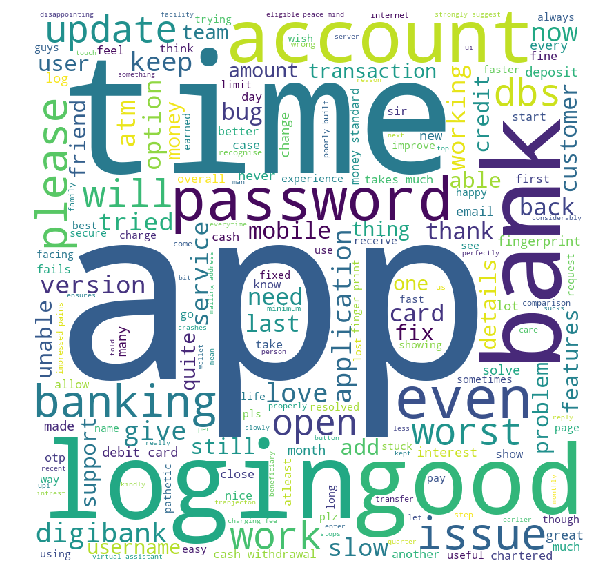

In [165]:
commentsDocument = getListOfComments().head(900)
showCloud(commentsDocument)

In [167]:
processed_doc = preprocessCommentDocument(commentsDocument)
# bow(processed_doc)

..given comments: Plz Launch Credit Card in Westbengal Quickly.......I think too much user wait for Credit Card

..tokens: ['Plz', 'Launch', 'Credit', 'Card', 'Westbengal', 'Quickly', 'wait', 'Credit', 'Card']



..given comments: the mail otp never arrives i tried so many times the mail otp never arrives i can even login to this

..tokens: ['mail', 'otp', 'time', 'mail', 'otp']



..given comments: Worst banking app. After tried for various times I am unable to log in to my account. God knows wht wll happen to my hard earned money😠😠🤯

..tokens: ['Worst', 'banking', 'app', 'time', 'account', 'God', 'happen', 'money😠😠\U0001f92f']



..given comments: Very impressive and easy use bank good effort and one step ahead for degetal india.. I love this bank..😘

..tokens: ['use', 'bank', 'effort', 'step', 'india..', 'bank..😘']



..given comments: It shows Technical issues everytime

..tokens: ['Technical', 'issue']



..given comments: I referred by my friend but I hadn't receive any amount as


..tokens: ['app', 'banking', 'way', 'Sir', 'application', 'application', 'comparison', 'application', 'service', 'request', 'time']



..given comments: Good app with nice offers.

..tokens: ['app', 'offer']



..given comments: Secure banking app

..tokens: ['Secure', 'banking', 'app']



..given comments: ATM card yaga

..tokens: ['ATM', 'card', 'yaga']



..given comments: Recent update solved the fingerprint issue. All the features are good but the BharatQR option fails in the app. Don't know what's the issue. Works fine with other banks.

..tokens: ['update', 'fingerprint', 'issue', 'feature', 'BharatQR', 'option', 'fails', 'app', 'issue', 'bank']



..given comments: Pls give passcode option to open the app

..tokens: ['Pls', 'passcode', 'option', 'app']



..given comments: The app is very useful,no more waiting for beneficiary adding....This app allows you instant addition of beneficiary and allows you to transfer money with no minimum cap for newly added.i love this banking a


..tokens: ['fix', 'Thanks']



..given comments: I am account holder of this bank but one problem facing from many times login issue,when i uninstall this app and again install so work some day after that repeated login issue .....Please Solve out this issue

..tokens: ['holder', 'bank', 'problem', 'time', 'issue', 'app', 'day', 'issue', '..Please', 'Solve', 'issue']



..given comments: Please add aadhar pay for marchent

..tokens: ['Please', 'pay', 'marchent']



..given comments: Sometimes it lags.. otherwise good.

..tokens: []



..given comments: Scan and pay not working

..tokens: []



..given comments: Too many bugs, can't add nominee, start SIP or a recurring deposit. It always fails at the last step.

..tokens: ['bug', 'SIP', 'deposit', 'step']



..given comments: Sir i am facing problem to set atm pin

..tokens: ['Sir', 'problem', 'pin']



..given comments: Worst update ...the older version was much better i have reinstalled it more than 3 times and still no response fro